In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.spatial import distance

folder = '/Volumes/Seagate Por 7/Pose Estimation'
os.chdir(folder)
files = sorted(glob.glob('*clean.h5'))
print('hay ' + str(len(files)) + ' archivos')

hay 96 archivos


In [56]:
track = pd.read_hdf(files[1])
track.head()

scorer    DLC_resnet50_test2Jun21shuffle1_200000                         \
bodyparts                                   chin                          
coords                                         x           y likelihood   
0                                     207.576309  277.541656   0.999022   
1                                     207.571671  277.588752   0.999012   
2                                     207.567032  277.635847   0.999003   
3                                     207.562394  277.682943   0.998993   
4                                     207.557755  277.730038   0.998984   

scorer                                                                \
bodyparts       mouth                               head               
coords              x           y likelihood           x           y   
0          208.902145  266.716370   0.997744  209.053329  253.048660   
1          208.904740  266.759554   0.997714  209.054832  253.098325   
2          208.907334  266.802739   0.997684  209.056334  253.147990   
3          208.909929  266.845923   0.997654  209.057836  253.197655   
4          208.912524  266.889108   0.997623  209.059338  253.247320   

scorer                                                               \
bodyparts                  body1                              body2   
coords    likelihood           x           y likelihood           x   
0           0.998171  206.669952  239.711823   0.995592  195.369385   
1           0.998165  206.673771  239.740547   0.995615  195.394392   
2           0.998158  206.677590  239.769272   0.995637  195.419399   
3           0.998152  206.681409  239.797997   0.995660  195.444405   
4           0.998145  206.685228  239.826722   0.995683  195.469412   

scorer                                                               
bodyparts                               tail                         
coords              y likelihood           x           y likelihood  
0          173.366196   0.975685  178.610901  145.388519   0.984965  
1          173.427970   0.975793  178.717349  145.411756   0.985032  
2          173.489745   0.975901  178.823796  145.434992   0.985100  
3          173.551519   0.976009  178.930244  145.458229   0.985167  
4          173.613293   0.976117  179.036692  145.481466   0.985235

In [57]:
track.isna().sum()

scorer                                  bodyparts  coords    
DLC_resnet50_test2Jun21shuffle1_200000  chin       x             0
                                                   y             0
                                                   likelihood    0
                                        mouth      x             0
                                                   y             0
                                                   likelihood    0
                                        head       x             0
                                                   y             0
                                                   likelihood    0
                                        body1      x             0
                                                   y             0
                                                   likelihood    0
                                        body2      x             0
                                                   y             0


In [59]:
def get_centroids(track, n_keypoints):
    centroids = []

    bodyparts = np.array([x for x in track.columns.get_level_values(1)])
    xpositions = pd.DataFrame(np.zeros((len(track),n_keypoints)), columns=np.unique(bodyparts))
    for i in range(n_keypoints):
        xpositions[np.unique(bodyparts)[i]] = (track[track.columns.get_level_values(0)[0], np.unique(bodyparts)[i], 'x'])
        
    median_xposition = np.median(xpositions, axis=1) #xpos

    ypositions = pd.DataFrame(np.zeros((len(track),n_keypoints)), columns=np.unique(bodyparts))
    for i in range(n_keypoints):
        ypositions[np.unique(bodyparts)[i]] = (track[track.columns.get_level_values(0)[0], np.unique(bodyparts)[i], 'y'])
        
    median_yposition = np.median(ypositions, axis=1) #ypos

    for j in range(len(median_xposition)):
        centroids.append([median_xposition[j], median_yposition[j]])

    return centroids

In [60]:
centroids = get_centroids(track, n_keypoints=6)

In [61]:
def calculate_velocity(centroids, sf, pix_to_cm):
    desplazamiento = [distance.euclidean(x,y)*pix_to_cm for x, y in zip(centroids[1:], centroids[:-1])]
    dt = len(centroids) / sf
    v = [i/dt for i in desplazamiento]

    return v

In [62]:
velocity = calculate_velocity(centroids, sf=50, pix_to_cm=12)

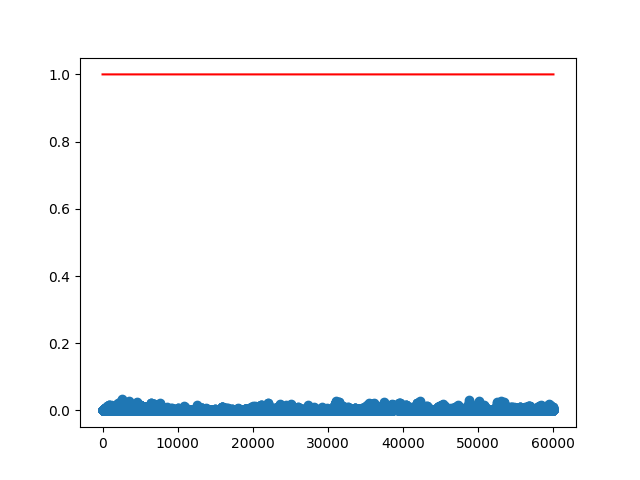

In [63]:
%matplotlib widget
plt.figure()
plt.plot(velocity)
plt.scatter(range(len(velocity)), velocity)
plt.plot(range(len(velocity)), [1 for x in velocity], c='r')

In [65]:
vel_per_frame = pd.DataFrame(zip([round(x[0]/12) for x in centroids], [round(y[1]/12) for y in centroids], velocity), columns=['x', 'y', 'v'])
vel_per_frame

,x,y,v
0,17,21,0.000391
1,17,21,0.000391
2,17,21,0.000391
3,17,21,0.000391
4,17,21,0.000391
...,...,...,...
60067,17,20,0.000000
60068,17,20,0.000000
60069,17,20,0.000000
60070,17,20,0.000000


In [66]:
grouped_v = vel_per_frame.groupby(['x', 'y']).median().reset_index()
v_grid = np.zeros(shape=(63,61))
v_grid = pd.DataFrame(v_grid).replace(0,np.nan)
for index, row in grouped_v.iterrows():
    coords = [int(row['x']), int(row['y'])]
    v_grid.iloc[coords[0], coords[1]] = row['v']

v_grid

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
grouped_v

,x,y,v
0,12,13,0.004470
1,13,12,0.003963
2,13,13,0.003078
3,13,24,0.004835
4,13,25,0.002445
...,...,...,...
95,20,24,0.002569
96,21,14,0.007534
97,21,15,0.006053
98,21,18,0.001382


In [68]:
def plot_map(grid, objCoordinates,cmap, label,filename, vmax=None,vmin=None):
    fig, ax = plt.subplots()
    plt.imshow(grid, cmap=cmap, vmax=vmax, vmin=vmin, origin='lower')
    cbar = plt.colorbar()
    cbar.set_label(label)
    #plt.scatter(objCoordinates[1]/10, objCoordinates[0]/10, s=100, c='k')
    #fig.savefig(filename, format='svg', dpi=1200)

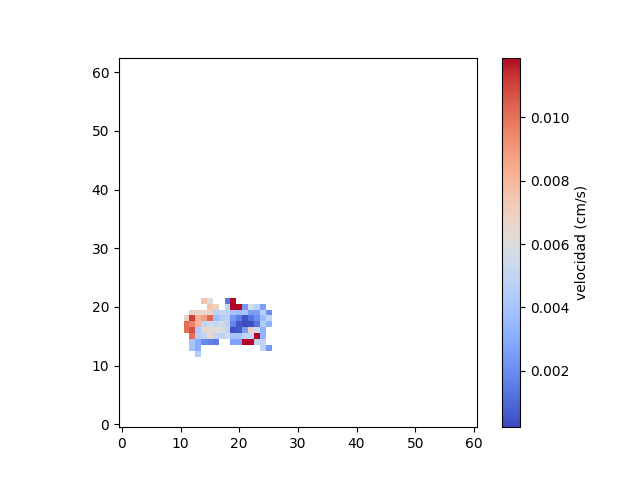

In [69]:
%matplotlib widget
plot_map(v_grid, [0,1], 'coolwarm', vmax=np.max(v_grid)*.75, label='velocidad (cm/s)', filename='a')


In [ ]:
|